# Домашнее задание "Бинарная классификация изображений и решение проблемы дисбаланса классов"

## Введение
В этом домашнем задании вы будете работать с задачей бинарной классификации изображений. Мы будем использовать датасет "Cats vs Dogs", чтобы создать модель, способную различать изображения кошек и собак. Тренировочный набор данных содержит 10 000 изображений кошек и 10 000 изображений собак. В тестовом наборе содержится по 2 500 картинок каждого класса.

Цель домашнего задания — закрепить знания о том, как загружать и предобрабатывать данные, определять и обучать нейронные сети, оценивать их эффективность и визуализировать результаты.

## Импорт необходимых библиотек
Для решения поставленной задачи вам понадобятся библиотеки для работы с числовыми данными, обучения нейронных сетей и отрисовки графиков. В этой части кода импортируйте необходимые библиотеки, установите seed для воспроизводимости результатов и определите устройство для работы — cpu или cuda.

In [1]:
import numpy as np
import random
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt

In [2]:
seed = 0

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Задание №1: Загрузка и предобработка данных
Теперь вам необходимо выполнить загрузку и предобработку данных. В качестве бейзлайна можете использовать следующие аугментации (обязательно поэкспериментируйте с другими!):
- изменение размера изображения до 224х224;
- случайное горизонтальное отражение;
- случайное изменение яркости, контраста, насыщенности и оттенка;
- преобразование в тензор.

Для тестового набора данных используйте только изменение размера до 224х224 и преобразование в тензор.

In [3]:
# Преобразования для обучающего набора данных
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor()
])

# Преобразования для тестового набора данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Датасет для скачивания вы можете найти по [ссылке](https://www.kaggle.com/datasets/salader/dogs-vs-cats?select=test). После скачивания откройте Google Drive (Google Диск) и загрузите архив в удобную для вас директорию.

In [4]:
# Подключение Google Диска
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Разархивирование скачанного архива (при необходимости замените пути)
# !unzip -q /content/drive/MyDrive/uni_files/archive.zip "train/*" "test/*" -d /content/dogs_vs_cats

Убедитесь, что в разделе `Файлы` у вас появилась папка следующего вида:
```
dogs_vs_cats/
├── train/
│   ├── cats/
│   └── dogs/
└── test/
    ├── cats/
    └── dogs/
```
После этого можно перейти к формированию датасета. При работе с данными такой структуры применяется функция `ImageFolder` из `torchvision.datasets`. Примените заданные трансформы. При необходимости измените пути к данным.

In [6]:
# Загрузка обучающего набора данных
train_data = datasets.ImageFolder(root='E:/UNI/PYTHON/CV/HW1/dogs_vs_cats/train', transform=train_transform)
test_data = datasets.ImageFolder(root='E:/UNI/PYTHON/CV/HW1/dogs_vs_cats/test', transform=test_transform)

## Создание несбалансированной выборки

Для усложнения задачи создадим несбалансированную версию датасета. В качестве редуцируемого класса выберем "cats".

In [7]:
import os
import random
from torchvision import datasets
from torch.utils.data import Subset

def create_imbalanced_dataset(dataset, percentage=0.1):
    # Разделим индексы по классам
    targets = np.array(train_data.targets)
    cats_indices = list(np.where(targets == 0)[0])
    dogs_indices = list(np.where(targets == 1)[0])
    # Выберем 10% от класса 'cats'
    selected_cats_indices = random.sample(cats_indices, int(len(cats_indices) * percentage))
    final_indices = selected_cats_indices + dogs_indices

    return Subset(dataset, final_indices)

In [8]:
imbalanced_train_data = create_imbalanced_dataset(train_data, percentage=0.1)

Теперь создайте загрузчики данных (DataLoader) для тренировочного и тестового наборов данных.  
Не забудьте про перемешивание обучающего набора данных перед каждой эпохой. Также задайте параметры *worker_init_fn* и *generator* для воспроизводимости.

In [9]:
imbalanced_train_loader = DataLoader(imbalanced_train_data, batch_size=64, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=True)

## Задание №2: Обучение модели на несбалансированных данных
Выберите модель и обучите ее на несбалансированных данных. Вы можете взять функцию для обучения из семинара, а лучше напишите свою. Не забывайте сохранять веса обученных моделей.

После обучения модели посмотрите отчет о классификации и матрицу ошибок, используя `classification_report` и `confusion_matrix` из `sklearn.metrics`. Что можно сказать о полученных метриках?

In [10]:
def train_model(train_loader, val_loader, model, criterion, optimizer, epochs):
  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []

  for epoch in range(epochs):
    model.train()

    train_loss = 0
    train_correct = 0
    train_total = 0
    for data in train_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      train_total += labels.size(0)
      train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)

    model.eval()

    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch:2d}  |  Train Loss: {train_losses[-1]:.6f}  |  Val Loss: {val_losses[-1]:.6f}  |  Train Accuracy: {train_accuracy:.2f}%  |  Val Accuracy: {val_accuracy:.2f}%')
  return model, train_losses, train_accuracies, val_losses, val_accuracies

classes = train_data.classes
num_classes = len(classes)
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)  

resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18.parameters(), lr=1e-3)

trained_resnet18, train_loss, train_acc, val_loss, val_acc = train_model(imbalanced_train_loader, test_loader, resnet18, criterion, optimizer, epochs=10)

torch.save(trained_resnet18.state_dict(), 'resnet18_imbalanced.pth')

all_preds = []
all_labels = []
trained_resnet18.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=classes))
print("Confusion matrix:")
print(confusion_matrix(all_labels, all_preds))


Epoch  0  |  Train Loss: 0.125717  |  Val Loss: 0.326032  |  Train Accuracy: 95.43%  |  Val Accuracy: 86.26%
Epoch  1  |  Train Loss: 0.075552  |  Val Loss: 0.429140  |  Train Accuracy: 97.27%  |  Val Accuracy: 81.96%
Epoch  2  |  Train Loss: 0.068166  |  Val Loss: 0.569154  |  Train Accuracy: 97.53%  |  Val Accuracy: 81.64%
Epoch  3  |  Train Loss: 0.054044  |  Val Loss: 0.300108  |  Train Accuracy: 98.21%  |  Val Accuracy: 89.20%
Epoch  4  |  Train Loss: 0.055647  |  Val Loss: 0.221060  |  Train Accuracy: 98.09%  |  Val Accuracy: 91.26%
Epoch  5  |  Train Loss: 0.047842  |  Val Loss: 0.154059  |  Train Accuracy: 98.38%  |  Val Accuracy: 93.66%
Epoch  6  |  Train Loss: 0.044877  |  Val Loss: 0.194804  |  Train Accuracy: 98.42%  |  Val Accuracy: 93.02%
Epoch  7  |  Train Loss: 0.035000  |  Val Loss: 0.171271  |  Train Accuracy: 98.82%  |  Val Accuracy: 93.08%
Epoch  8  |  Train Loss: 0.029031  |  Val Loss: 0.377381  |  Train Accuracy: 98.94%  |  Val Accuracy: 90.70%
Epoch  9  |  Train 

## Решение проблемы дисбаланса классов
Чтобы модель могла лучше предсказывать малопредставленные классы, необходимо использовать специальные методы, для адаптации процесса обучения. Рассмотрим такие подходы.


## Задание №3: Resampling
Resampling включает в себя ве техники — **under**sampling и **over**sampling.

**Undersampling** — это метод, направленный на борьбу с дисбалансом классов, при котором количество объектов в более часто встречающихся классах уменьшается, чтобы выровнять количество объектов в каждом классе.
Этот подход эффективен, когда объем данных велик, и удаление части данных не приведет к значительной потере информации. Его основное преимущество — это сокращение времени и ресурсов, необходимых для обучения модели. Однако минус заключается в том, что важная информация может быть потеряна, если вместе с избыточными данными удаляются редкие события или аномалии.

**Oversampling**, наоборот, увеличивает количество примеров в менее представленном классе за счет дублирования существующих примеров или генерации новых синтетических данных.
Этот метод сохраняет всю информацию исходного набора данных, увеличивая вероятность того, что модель научится распознавать менее частые классы.

![resampling](https://blog.strands.com/hs-fs/hubfs/Screenshot%202019-07-18%20at%2014.15.15.png?width=1800&name=Screenshot%202019-07-18%20at%2014.15.15.png)

Реализуйте оба метода, используя `WeightedRandomSampler` из `torch.utils.data`. Вычислите веса для классов на основе обратной частоты их появления. Передайте список весов для каждого элемента в наборе данных в качестве аргумента `WeightedRandomSampler`. Полученный семплер используйте при создании DataLoader.

### Undersampling

In [11]:
# YOUR CODE HERE
from torch.utils.data import WeightedRandomSampler
def get_sample_weights(dataset):
    if isinstance(dataset, Subset):
        targets = []
        for idx in dataset.indices:
            _, label = dataset.dataset[idx]
            targets.append(label)
    else:
        targets = [dataset[i][1] for i in range(len(dataset))]

    class_counts = np.bincount(targets)
    class_weights = 1.0 / class_counts

    sample_weights = [class_weights[t] for t in targets]
    return sample_weights

sample_weights = get_sample_weights(imbalanced_train_data)
class_counts = np.bincount([imbalanced_train_data[i][1] for i in range(len(imbalanced_train_data))])
min_class_count = int(min(class_counts))
desired_num_samples = min_class_count * 2 

len_imbalanced = len(imbalanced_train_data)
if desired_num_samples > len_imbalanced:
    desired_num_samples = len_imbalanced

undersampler = WeightedRandomSampler(weights=sample_weights, num_samples=desired_num_samples, replacement=False)

undersampled_train_loader = DataLoader(imbalanced_train_data, batch_size=64, sampler=undersampler, num_workers=0 ,worker_init_fn=seed_worker, generator=g, pin_memory=True)



### Oversampling

In [12]:
# YOUR CODE HERE
oversampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(imbalanced_train_data), replacement=True)
oversampled_train_loader = DataLoader(imbalanced_train_data, batch_size=64, sampler=oversampler, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=True)

Сравните метрики с теми, что были получены при первоначальнои обучении. Удалось ли повысить качество модели?



\\удалось

In [13]:
# YOUR CODE HERE
def evaluate_model(model, data_loader, classes):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    print("Confusion matrix:")
    print(confusion_matrix(all_labels, all_preds))
    
print("\n--------------------OVERSAMPLING--------------------")
resnet18_over = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

resnet18_over.fc = nn.Linear(in_features=resnet18_over.fc.in_features, out_features=num_classes)
resnet18_over = resnet18_over.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18_over.parameters(), lr=1e-3)

trained_resnet18_over, train_loss_over, train_acc_over, val_loss_over, val_acc_over = train_model(oversampled_train_loader, test_loader, resnet18_over, criterion, optimizer, epochs=10)
torch.save(trained_resnet18_over.state_dict(), 'resnet18_imbalanced_oversampling.pth')
evaluate_model(trained_resnet18_over, test_loader, classes)

print("\n--------------------UNDERSAMPLING--------------------")
resnet18_under = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18_under.fc = nn.Linear(in_features=resnet18_under.fc.in_features, out_features=num_classes)
resnet18_under = resnet18_under.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet18_under.parameters(), lr=1e-3)

trained_resnet18_under, train_loss_under, train_acc_under, val_loss_under, val_acc_under = train_model(undersampled_train_loader, test_loader, resnet18_under, criterion, optimizer, epochs=10)
torch.save(trained_resnet18_under.state_dict(), 'resnet18_imbalanced_undersampling.pth')
evaluate_model(trained_resnet18_under, test_loader, classes)


--------------------OVERSAMPLING--------------------
Epoch  0  |  Train Loss: 0.140029  |  Val Loss: 0.571030  |  Train Accuracy: 94.41%  |  Val Accuracy: 87.06%
Epoch  1  |  Train Loss: 0.068733  |  Val Loss: 0.127486  |  Train Accuracy: 97.38%  |  Val Accuracy: 95.10%
Epoch  2  |  Train Loss: 0.064983  |  Val Loss: 0.123626  |  Train Accuracy: 97.48%  |  Val Accuracy: 94.96%
Epoch  3  |  Train Loss: 0.043497  |  Val Loss: 0.176550  |  Train Accuracy: 98.44%  |  Val Accuracy: 94.58%
Epoch  4  |  Train Loss: 0.039291  |  Val Loss: 0.150140  |  Train Accuracy: 98.63%  |  Val Accuracy: 95.24%
Epoch  5  |  Train Loss: 0.043875  |  Val Loss: 0.138884  |  Train Accuracy: 98.46%  |  Val Accuracy: 95.06%
Epoch  6  |  Train Loss: 0.028203  |  Val Loss: 0.160115  |  Train Accuracy: 99.01%  |  Val Accuracy: 94.22%
Epoch  7  |  Train Loss: 0.032835  |  Val Loss: 0.182029  |  Train Accuracy: 98.82%  |  Val Accuracy: 93.88%
Epoch  8  |  Train Loss: 0.023444  |  Val Loss: 0.198442  |  Train Accurac

## Задание №4: Взвешивание классов
Другой подход, используемый при дисбалансе — взвешивание классов. Этот метод позволяет уменьшить предвзятость модели к более представленным классам, назначая больший вес ошибкам на менее представленных классах. Веса классов обычно вычисляются на основе обратной зависимости от частоты классов в данных. Полученные веса используются в качестве аргмента функции потерь.

Взвесьте классы согласно этой формуле:
$$ w_i = \frac{1}{n_i} $$
где:  
$w_i$ — вес для $i$-го класса;  
$n_i$ — число объектов $i$-го класса.

Полученые веса передайте в качестве аргумента функции потерь и запустите обучение.

In [14]:
# YOUR CODE HERE
targets = [imbalanced_train_data[i][1] for i in range(len(imbalanced_train_data))]
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts

class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
imbalanced_train_loader = DataLoader(imbalanced_train_data, batch_size=64, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=True)

num_classes = 2
resnet18_weighted = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18_weighted.fc = nn.Linear(in_features=resnet18_weighted.fc.in_features, out_features=num_classes)
resnet18_weighted = resnet18_weighted.to(device)

optimizer = optim.AdamW(resnet18_weighted.parameters(), lr=1e-3)

trained_resnet18_weighted = train_model(imbalanced_train_loader, test_loader, resnet18_weighted, criterion, optimizer, epochs=10)
torch.save(trained_resnet18_weighted[0].state_dict(), "resnet18_weighted.pth")


Epoch  0  |  Train Loss: 0.307070  |  Val Loss: 0.369433  |  Train Accuracy: 89.56%  |  Val Accuracy: 88.84%
Epoch  1  |  Train Loss: 0.198638  |  Val Loss: 0.247978  |  Train Accuracy: 93.21%  |  Val Accuracy: 88.84%
Epoch  2  |  Train Loss: 0.153725  |  Val Loss: 1.125126  |  Train Accuracy: 94.74%  |  Val Accuracy: 67.52%
Epoch  3  |  Train Loss: 0.149902  |  Val Loss: 0.416481  |  Train Accuracy: 94.54%  |  Val Accuracy: 83.58%
Epoch  4  |  Train Loss: 0.125227  |  Val Loss: 0.178679  |  Train Accuracy: 95.27%  |  Val Accuracy: 92.34%
Epoch  5  |  Train Loss: 0.092635  |  Val Loss: 0.174021  |  Train Accuracy: 96.55%  |  Val Accuracy: 93.72%
Epoch  6  |  Train Loss: 0.114880  |  Val Loss: 0.134588  |  Train Accuracy: 95.84%  |  Val Accuracy: 94.32%
Epoch  7  |  Train Loss: 0.082447  |  Val Loss: 0.136217  |  Train Accuracy: 96.99%  |  Val Accuracy: 94.86%
Epoch  8  |  Train Loss: 0.097166  |  Val Loss: 0.147766  |  Train Accuracy: 96.39%  |  Val Accuracy: 94.06%
Epoch  9  |  Train 

Снова проверьте метрики на тестовом наборе данных.

In [15]:
# YOUR CODE HERE
evaluate_model(trained_resnet18_weighted[0], test_loader, classes)

Classification report:
              precision    recall  f1-score   support

        cats       0.93      0.93      0.93      2500
        dogs       0.93      0.93      0.93      2500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000

Confusion matrix:
[[2326  174]
 [ 165 2335]]


## Задание №5: Focal Loss
Focal Loss — это функция потерь, используемая в задачах классификации для решения проблемы несбалансированных классов. Focal Loss модифицирует стандартную кросс-энтропийную потерю так, чтобы уменьшить влияние легко классифицируемых объектов на обучение модели и увеличить влияние "сложных", мало представленных объектов.
$$ FL(p_t) = -\sum_{c=1}^C \alpha_c (1 - p_{t,c})^\gamma \log(p_{t,c}) $$
где:  
$p_t$ — вероятность принадлежности к целевому классу;  
$\alpha_c$ — весовой коэффициент для класса $c$;  
$\gamma$ — параметр, регулирующий степень уменьшения веса легко классифицируемых объектов.

Случай $\gamma=0$ соотвествует кросс-энтропийной функции потерь. Значение параметра $\gamma>0$ уменьшает относительные потери для хорошо классифицированных объектов (верно предсказанных с высокой вероятностью), уделяя больше внимания сложным, неправильно классифицированным объектам.

![focal_loss](https://i2.wp.com/miro.medium.com/1*zvntw5mnlWLR7zUMKCS_AA.png)

Реализуйте функцию Focal Loss и задайте ее в качестве функции потерь при обучении модели.

In [16]:
def focal_loss(inputs, targets, gamma=2, reduce=True, eps=1e-8):
    inputs = inputs.softmax(dim=1)
    p_t = inputs.gather(1, targets.view(-1, 1))
    
    class_counts = torch.bincount(targets, minlength=inputs.size(1)).float()
    total_count = targets.size(0)
    class_weights = total_count / (class_counts + eps)
    
    alpha = class_weights[targets]
    loss = -alpha * (1 - p_t) ** gamma * torch.log(p_t + eps)
    
    if reduce:
        return loss.mean()
    else:
        return loss

class_counts = np.bincount(targets)
class_counts = torch.tensor(class_counts, dtype=torch.float32).to(device)

resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)

resnet18 = resnet18.to(device)

optimizer = optim.AdamW(resnet18.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_resnet18_focal_loss, train_loss, train_acc, val_loss, val_acc = train_model(oversampled_train_loader, test_loader, resnet18, focal_loss, optimizer, epochs=3)

torch.save(trained_resnet18_focal_loss.state_dict(), 'trained_resnet18_focal_loss_optimized.pth')

Epoch  0  |  Train Loss: 0.037253  |  Val Loss: 0.017006  |  Train Accuracy: 97.29%  |  Val Accuracy: 97.94%
Epoch  1  |  Train Loss: 0.015831  |  Val Loss: 0.015507  |  Train Accuracy: 99.07%  |  Val Accuracy: 98.24%
Epoch  2  |  Train Loss: 0.007033  |  Val Loss: 0.030031  |  Train Accuracy: 99.61%  |  Val Accuracy: 97.28%


Посчитайте метрики на тестовом наборе данных. Какой из подходов дал наилучший результат?

In [17]:
# YOUR CODE HERE
evaluate_model(trained_resnet18_focal_loss, test_loader, classes)

Classification report:
              precision    recall  f1-score   support

        cats       0.99      0.95      0.97      2500
        dogs       0.95      0.99      0.97      2500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

Confusion matrix:
[[2379  121]
 [  15 2485]]


## Задание №6: Выбор лучшей модели и получение предсказаний
Выберите лучшую модель и сделайте предсказания на тестовом наборе данных. Визуализируйте полученные результаты.

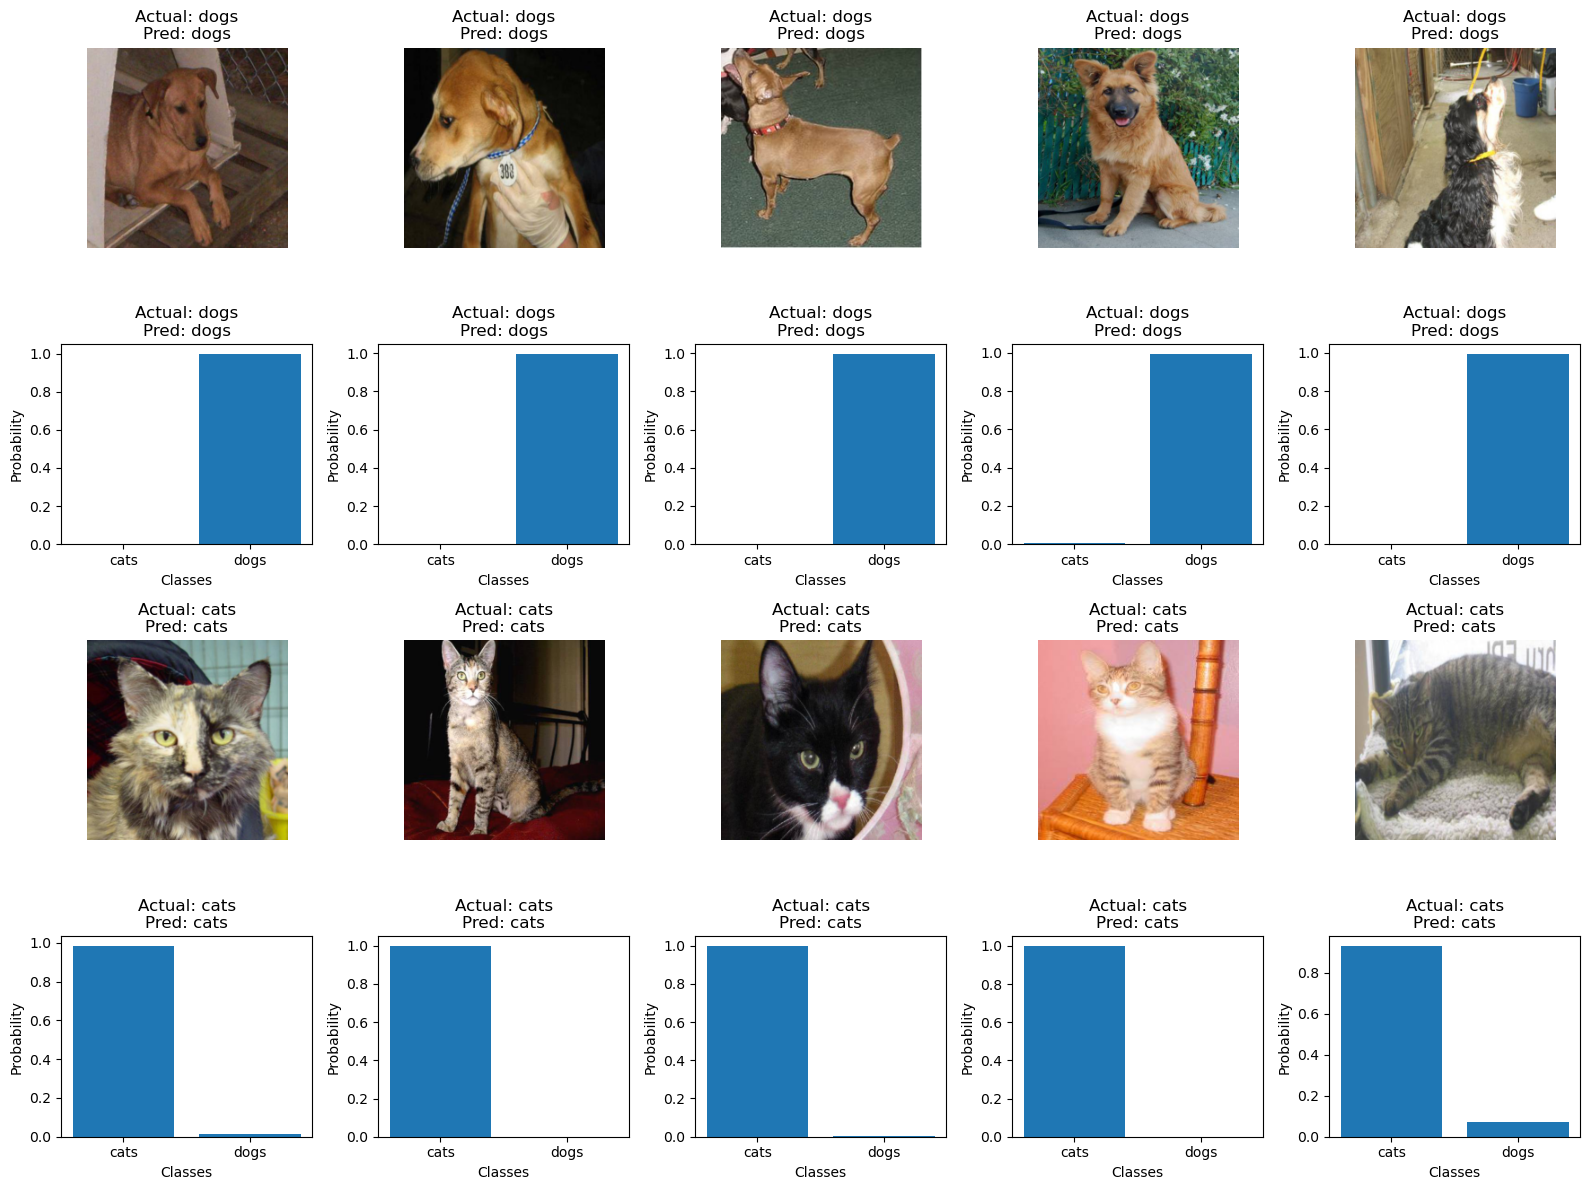

In [18]:
from PIL import Image

def show_image(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

def analyze_images(model, dogs_folder, cats_folder, classes, num_images=5):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    dog_image_paths = [os.path.join(dogs_folder, f) 
                       for f in os.listdir(dogs_folder) 
                       if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    dog_image_paths = dog_image_paths[:num_images]

    cat_image_paths = [os.path.join(cats_folder, f) 
                       for f in os.listdir(cats_folder) 
                       if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    cat_image_paths = cat_image_paths[:num_images]

    device = next(model.parameters()).device

    plt.figure(figsize=(16, 12))

    for i, image_path in enumerate(dog_image_paths):
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)

        title_text = f"Actual: dogs\nPred: {classes[predicted.item()]}"

        plt.subplot(4, num_images, i + 1)
        show_image(img_tensor.squeeze(), title_text)

        plt.subplot(4, num_images, i + 1 + num_images)
        probs = probabilities.squeeze().cpu().detach().numpy()
        plt.bar(range(len(classes)), probs, tick_label=classes)
        plt.title(title_text)
        plt.xlabel('Classes')
        plt.ylabel('Probability')

    for i, image_path in enumerate(cat_image_paths):
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)

        title_text = f"Actual: cats\nPred: {classes[predicted.item()]}"

        plt.subplot(4, num_images, i + 1 + 2 * num_images)
        show_image(img_tensor.squeeze(), title_text)

        plt.subplot(4, num_images, i + 1 + 3 * num_images)
        probs = probabilities.squeeze().cpu().detach().numpy()
        plt.bar(range(len(classes)), probs, tick_label=classes)
        plt.title(title_text)
        plt.xlabel('Classes')
        plt.ylabel('Probability')

    plt.tight_layout()
    plt.show()

dogs_folder = 'E:/UNI/PYTHON/CV/HW1/dogs_vs_cats/test/dogs'
cats_folder = 'E:/UNI/PYTHON/CV/HW1/dogs_vs_cats/test/cats'
analyze_images(resnet18, dogs_folder, cats_folder, classes, num_images=5)

## Заключение
В этом домашнем задании вы закрепили знания по подготвке данных и обучению нейронных сетей, а также научились решать проблему несбалансированного датасета.
Полученные знания и навыки позволят вам успешно решать задачи классификации изображений.